In [414]:
import sys
import os
import math
import numpy
import logging
import time
import galsim

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'legend.title_fontsize': 16})
rcParams.update({'axes.titlesize': 16})

from utils import *

### Comparison of Moffat PSF in Astropy and Galsim

In [249]:
# Parameters
pixel_scale = 2.5           # arcsec/pixel
psf_beta = 3       # beta
fwhm = 2.2 * 2.5      # arcsec
gamma = fwhm / 2. / np.sqrt(2**(1./psf_beta)-1) #in arcsec
gamma_pix = gamma / pixel_scale  #in pix

print(" Core Width: %.2f''/ %.2f pix, Power Index: %.2f"%(gamma, gamma_pix, psf_beta))

image_size = 64                 # size of image in pixels
image_size_arcsec = image_size * pixel_scale # size of big image in each dimension (arcsec)

random_seed = 24783923
rng = galsim.BaseDeviate(random_seed)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-4)
psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

# Draw the image
img_gs = psf.drawImage(scale=pixel_scale, method="fft").array

 Core Width: 5.39''/ 2.16 pix, Power Index: 3.00


Text(0.5, 1.0, 'Galsim 2D Moffat')

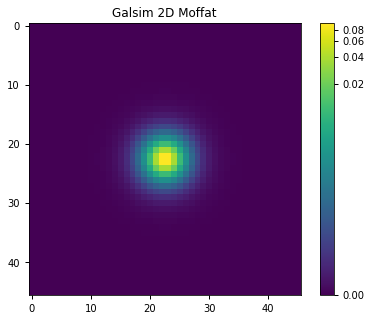

In [250]:
plt.figure(figsize=(7,5))
im = plt.imshow(img_gs, vmin=0, vmax=img_gs.max(), norm=norm1)
plt.colorbar(im)
plt.title("Galsim 2D Moffat")

#### Moffat:  $f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta}$

$A = \frac{\Gamma(\beta)}{R\sqrt{\pi} \Gamma(\beta-\frac{1}{2})}$ 

${\rm FWHM} := 2(r_{1/2} - r_0) = 2 R \sqrt{2^{1/\beta}-1}$

In [445]:
from scipy.special import gamma as G
def norm_moffat(width, power):
    return 2 * G(power) / (width * np.sqrt(np.pi) * G(power - 1/2))

def Moffat_Flux2Amp(r_core, beta, F=1, pixel_scale=pixel_scale):
    """ Calculate the (astropy) amplitude of 2d Moffat profile given the core width, power index, and total flux F.
    Note in astropy unit (x,y) the amplitude should be scaled with 1/sqrt(pi)."""
    C = np.sqrt(np.pi) * pixel_scale**psf_beta  # Extra scaling factor
    Amp = 1 / np.pi * F * Gamma(beta) / ( r_core * np.sqrt(np.pi) * Gamma(beta-1./2) ) # Derived scaling factor
    return  Amp

Amplitude(pix/arcsec): 0.125/ 0.050 / 0.315
Maximum R: 23 (pix)


Text(0.5, 1.0, 'Astropy 1D Moffat vs Galsim 2D Moffat')

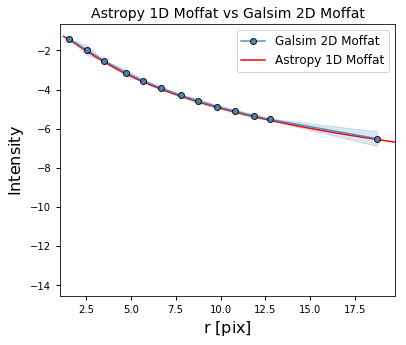

In [255]:
r = np.logspace(0.1,2.5,1000)

amp_pix = Moffat_Flux2Amp(r_core=gamma_pix, beta=psf_beta, F=1, pixel_scale=pixel_scale) 
amp_arcsec = Moffat_Flux2Amp(r_core=gamma, beta=psf_beta, F=1, pixel_scale=pixel_scale) 
A = norm_moffat(gamma, psf_beta)
print("Amplitude(pix/arcsec): %.3f/ %.3f / %.3f"%(amp_pix,amp_arcsec, A))

# Moffat in pixel
m1d = models.Moffat1D(amplitude=amp_pix, x_0=0, gamma=gamma_pix, alpha=psf_beta)

plt.figure(figsize=(6,5))
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_gs, pix_scale=pixel_scale,
                                                         xunit="pix", yunit="intensity", label="Galsim 2D Moffat")
plt.plot(r, np.log10(m1d(r)), ls="-",color="r",zorder=1, label="Astropy 1D Moffat")
plt.legend(fontsize=12)
plt.xlabel(r"r $\rm[pix]$",fontsize=16)
plt.ylabel(r"$\rm Intensity$",fontsize=16)
# plt.xscale("log")
plt.title("Astropy 1D Moffat vs Galsim 2D Moffat",fontsize=14)

Text(0.5, 1.0, 'Astropy 2D Moffat')

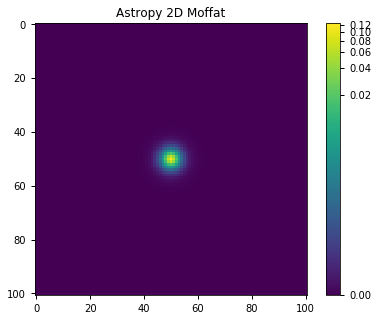

In [258]:
tshape = (101,101)
yy, xx = np.indices(tshape)
cen = (tshape[0]-1)/2., (tshape[1]-1)/2.
rr = np.sqrt((xx - cen[0])**2 + (yy - cen[1])**2)

m2d = models.Moffat2D(amplitude=amp_pix, x_0=cen[0], y_0=cen[1], gamma=gamma_pix, alpha=psf_beta)
img_astopy = m2d(xx,yy)
# img_astopy /= img_astopy.sum()

plt.figure(figsize=(7,5))
im = plt.imshow(img_astopy, vmin=0, vmax=img_astopy.max(), norm=norm1)
plt.colorbar(im)
plt.title("Astropy 2D Moffat")

Maximum R: 45 (pix)
Maximum R: 23 (pix)
Maximum R: 45 (pix)
Normalized Factor: 


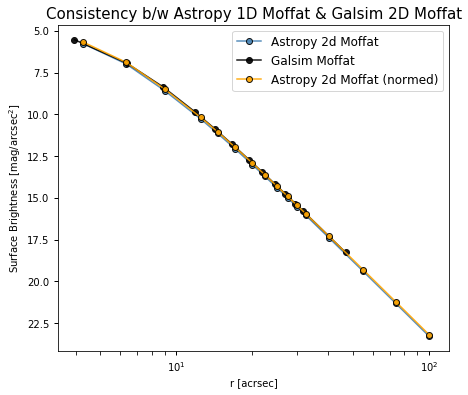

In [259]:
from astropy.convolution import Kernel
# IMPORTANT: use .copy() to build astropy kernel, otherwise .normalize will change the image
psf_model_astropy = Kernel(img_astopy.copy()) 
psf_model_astropy.normalize(mode="integral")

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_astopy, xunit="arcsec", yunit="SB",
                                                         pix_scale=pixel_scale, label="Astropy 2d Moffat")
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_gs, xunit="arcsec",yunit="SB",
                                                         pix_scale=pixel_scale, color="k", label="Galsim Moffat")
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(psf_model_astropy.array, xunit="arcsec", yunit="SB",
                                                         pix_scale=pixel_scale, color="orange", label="Astropy 2d Moffat (normed)")
plt.legend(fontsize=12)
plt.title("Consistency b/w Astropy 1D Moffat & Galsim 2D Moffat",fontsize=15)
print("Normalized Factor: ")

## Make Mock Image

#### 1. Galsim convolution without interpolation. 

This is to show how direct position parsing affects results. Here to reduce effect of finite image size for star stamp, we enlarge the image by changing the gsparam to let the image has its included flux = 1 - std(bkg)/amp.

In [261]:
# Parameters
pixel_scale = 2.5           # arcsec/pixel
beta_psf = 3       # beta
fwhm = 2.2 * 2.5      # arcsec
gamma = fwhm / 2. / np.sqrt(2**(1./psf_beta)-1) #in arcsec
gamma_pix = gamma / pixel_scale  #in pix
image_size = 256                 # size of image in pixels
noise_variance = 1e-4

random_seed = 24783923
rng = galsim.BaseDeviate(random_seed)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1e-3)
psf = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

In [270]:
# Generate star positions (uniform) and fluxs (log normal)
from scipy import stats
np.random.seed(512)
n_star = 100
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1
# star_pos = np.around(star_pos)

np.random.seed(512)
Fluxs = 10**stats.lognorm.rvs(s=0.3, loc=1., scale=1., size=n_star)
# Convert Fluxs (arcsec) to Astropy Moffat Amplitude (pixel)
Amps = [Moffat_Flux2Amp(r_core=gamma_pix, beta=beta_psf, F=F) for F in Fluxs]

gsparams_list = [galsim.GSParams(folding_threshold=math.sqrt(noise_variance)/amp) for amp in Amps]

In [271]:
# Setup the image:
full_image = galsim.ImageF(image_size, image_size)
noise_image = galsim.ImageF(image_size, image_size)

start = time.time()
for k, (pos, flux, gspar) in enumerate(zip(star_pos, Fluxs, gsparams_list)): 
    time1 = time.time()
#     ud = galsim.UniformDeviate(random_seed+k+1)
#     x_pos = ud() * image_size
#     y_pos = ud() * image_size

    x_pos, y_pos = pos[0] + 1, pos[1] + 1
    star = galsim.Moffat(beta=beta_psf, flux=flux, fwhm=fwhm, gsparams=gspar)
    
    # Creates a new object that has the same profile as the original, 
    # but with the surface brightness at every location rescaled such that the total flux
#     star = psf.withFlux(amp)

    stamp = star.drawImage(scale=pixel_scale, method='fft')
    stamp.setCenter(x_pos, y_pos)
    
    # Find the overlapping bounds:
    bounds = stamp.bounds & full_image.bounds
    full_image[bounds] += stamp[bounds]
    
    time2 = time.time()
    tot_time = time2-time1
    print("Time: %.3fs"%tot_time)
    
noise = galsim.GaussianNoise(rng, sigma=math.sqrt(noise_variance))
full_image.addNoise(noise)
noise_image.addNoise(noise)

end = time.time()
print("\nTotal Time: %.3fs"%(end-start))

image_gs = full_image.array + 1

Time: 0.012s
Time: 0.011s
Time: 0.011s
Time: 0.010s
Time: 0.010s
Time: 0.007s
Time: 0.009s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.007s
Time: 0.007s
Time: 0.007s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s
Time: 0.005s

Make mock image using superposition of Astropy Moffat Models.

In [272]:
gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1) #in arcsec
gamma_pix = gamma / pixel_scale  #in pix

moffat2d_s = [models.Moffat2D(amplitude=amp, x_0=x0-0.5, y_0=y0-0.5, gamma=gamma_pix, alpha=beta_psf) 
              for (amp, (x0,y0)) in zip(Amps, star_pos)]
yy, xx = np.mgrid[:image_size, :image_size]

psf_size = 101
cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
m2d_norm = models.Moffat2D(amplitude=1, x_0=cen_psf[0], y_0=cen_psf[1], 
                           gamma=gamma_pix, alpha=beta_psf)
norm = m2d_norm(xx_psf,yy_psf).sum()

start=time.time()
# image_astropy = np.sum([m2d(xx,yy) for m2d in moffat2d_s], axis=0) + 1 #+ noise_image.array
image_astropy = np.zeros((image_size,image_size))
for m2d in moffat2d_s:
    stamp = m2d(xx,yy)
    image_astropy += stamp
image_astropy += 1 + noise_image.array
end=time.time()
print("Time to generate the image: %.3gs"%(end-start))

Time to generate the image: 0.49s


Without Interpolation, when given the position of stars, Galsim round the center to integer, therefore has offsets, which leads to the dipole pattern shown in the third figure.

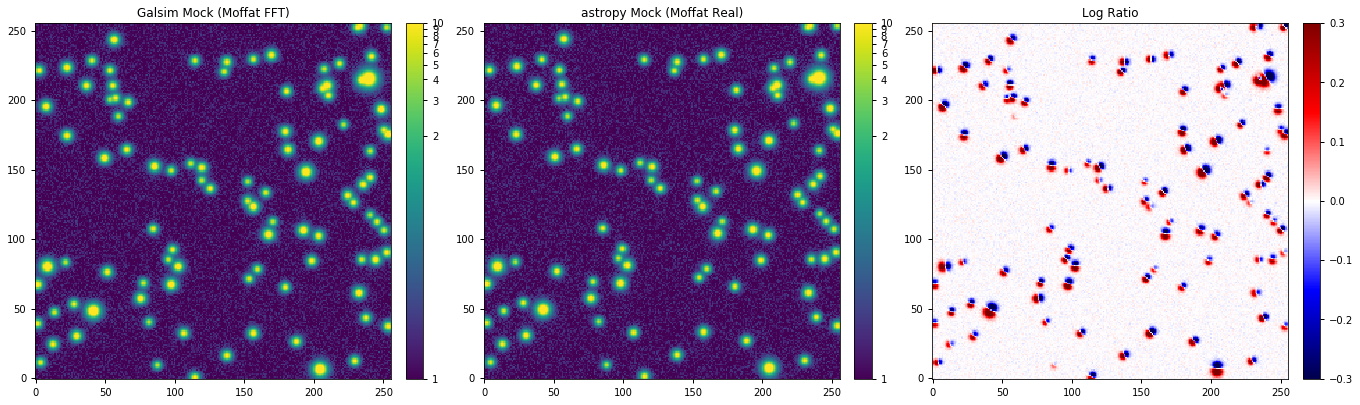

In [273]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(19,6))
im1 = ax1.imshow(image_gs, vmin=1, vmax=10., norm=norm1, origin="lower")
ax1.set_title("Galsim Mock (Moffat FFT)")
colorbar(im1)
im2 = ax2.imshow(image_astropy, cmap='viridis', aspect='equal', norm=norm1, vmin=1, vmax=10, origin='lower')
ax2.set_title("astropy Mock (Moffat Real)")
colorbar(im2)
im3 = ax3.imshow(np.log10(image_gs/image_astropy), cmap='seismic', aspect='equal', vmin=-.3, vmax=.3, origin='lower')
colorbar(im3)
ax3.set_title("Log Ratio")
plt.tight_layout()

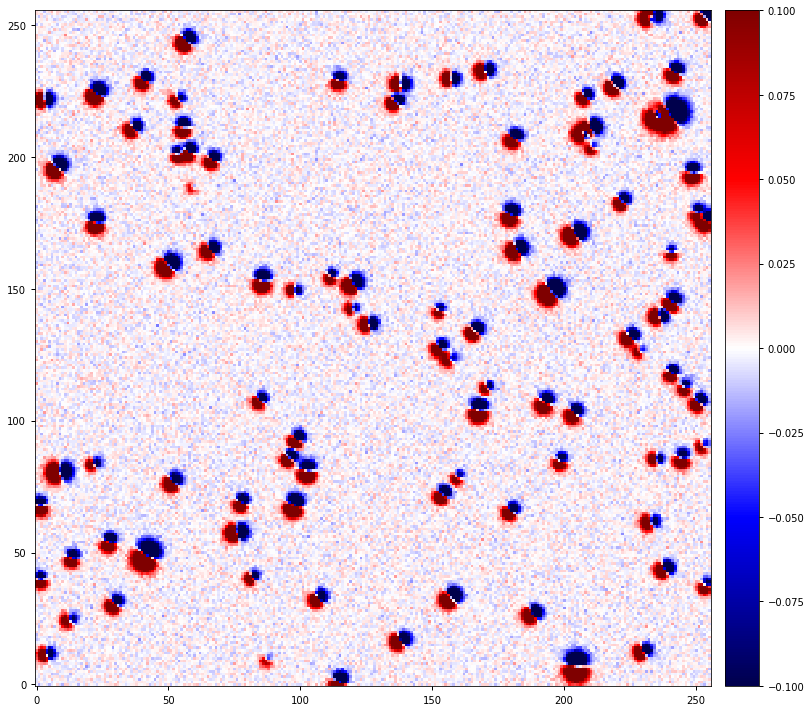

In [274]:
plt.figure(figsize=(10,9))
im = plt.imshow(np.log10(image_gs/image_astropy), cmap='seismic', aspect='equal', vmin=-0.1, vmax=0.1, origin='lower')
colorbar(im)
plt.tight_layout()

Below show the case when the star position are exactly integers, i.e. the centers are exactly matched. There are still difference between Astropy superpositions and Galsim convolution, but is smaller than 10^0.1 ~ 1.25. Not sure what causes this difference. (Maybe the normalization factor of Astropy image?)

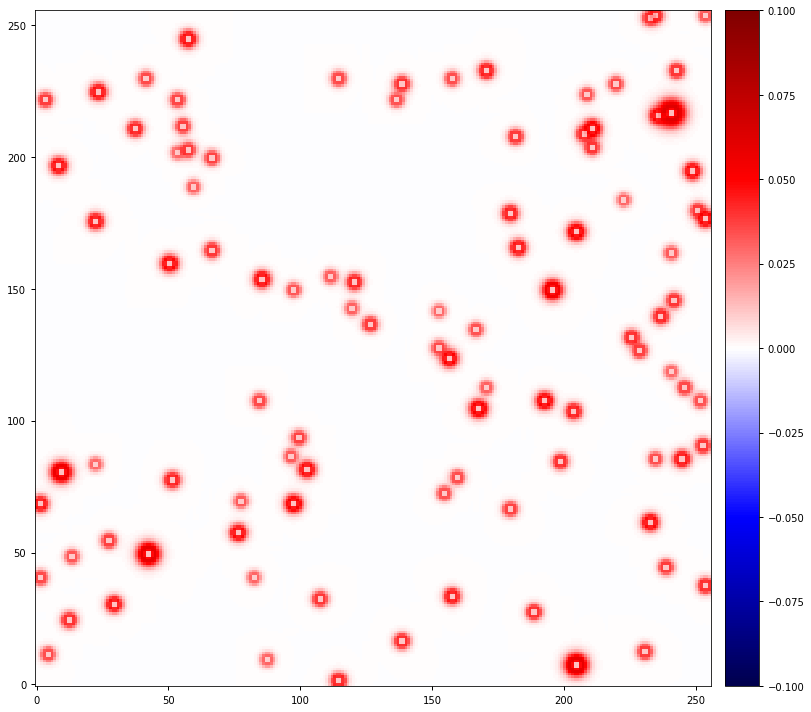

In [269]:
plt.figure(figsize=(10,9))
im = plt.imshow(np.log10(image_gs/image_astropy), cmap='seismic', aspect='equal', vmin=-0.1, vmax=0.1, origin='lower')
colorbar(im)
plt.tight_layout()

#### 2. Galsim convolution with resizing and interpolation. 

Because Galsim only accpets stamp position as integers, we build a galsim image with K * target size, and then downsample the image to the target shape. This is for increasing the precision of PSF positions. Note for stars at the image edge, there might be downsampling issues, so we add pads to the builded galsim image, and then crop the final image. 

Again we change the gsparam to enlarge image size.

In [514]:
# Parameters
pixel_scale = 2.5           # arcsec/pixel
beta_psf = 3       # beta
fwhm = 2.2 * 2.5      # arcsec
gamma = fwhm / 2. / np.sqrt(2**(1./psf_beta)-1) #in arcsec
gamma_pix = gamma / pixel_scale  #in pix

K = 4   # scaling factor, must be power of 2
image_size = 256                 # size of target image in pixels
image_Ksize = 256 * K           
pad_size = image_Ksize//K//2        # pad size
image_Kpsize = image_Ksize + 2 * pad_size   # size of K-scaled image w/ pads
noise_variance = 1e-4

random_seed = 24783923
rng = galsim.BaseDeviate(random_seed)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-3)
psf = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

In [515]:
# Generate star positions (uniform) and fluxs (log normal)
from scipy import stats
np.random.seed(512)
n_star = 100
# star_pos = image_size * np.random.random(size=(n_star,2))+1
# star_pos_scaled =  (K + (1. - K)/image_size) * (star_pos - 0.5) + 0.5
star_pos_scaled =  pad_size + K * star_pos

np.random.seed(512)
Fluxs = 10**stats.lognorm.rvs(s=0.3, loc=1., scale=1., size=n_star)
# Convert Fluxs (arcsec) to Astropy Moffat Amplitude (pixel)
Amps = [Moffat_Flux2Amp(r_core=gamma_pix, beta=beta_psf, F=F, pixel_scale=pixel_scale/K) for F in Fluxs]

gsparams_list = [galsim.GSParams(folding_threshold=math.sqrt(noise_variance)/amp) for amp in Amps]

In [516]:
# Setup the image:
full_image = galsim.ImageF(image_Kpsize, image_Kpsize)

start = time.time()
for k, (pos, flux, gspar) in enumerate(zip(star_pos_scaled, Fluxs, gsparams_list)): 
    time1 = time.time()

    x_pos, y_pos = np.around(pos) + 1
    star = galsim.Moffat(beta=psf_beta, flux=flux*K*K, fwhm=fwhm, gsparams=gspar)

    stamp = star.drawImage(scale=pixel_scale/K, method='fft')
    stamp.setCenter(x_pos, y_pos)
    
    # Find the overlapping bounds:
    bounds = stamp.bounds & full_image.bounds
    full_image[bounds] += stamp[bounds]
    
    time2 = time.time()
    tot_time = time2-time1
    print("Time: %.3fs"%tot_time)

end = time.time()
print("\nTotal Time: %.3fs"%(end-start))

image_gs = full_image.array

Time: 0.005s
Time: 0.004s
Time: 0.005s
Time: 0.004s
Time: 0.004s
Time: 0.005s
Time: 0.010s
Time: 0.004s
Time: 0.004s
Time: 0.004s
Time: 0.004s
Time: 0.004s
Time: 0.004s
Time: 0.006s
Time: 0.004s
Time: 0.004s
Time: 0.003s
Time: 0.003s
Time: 0.004s
Time: 0.003s
Time: 0.003s
Time: 0.004s
Time: 0.004s
Time: 0.006s
Time: 0.016s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.004s
Time: 0.003s
Time: 0.003s
Time: 0.003s
Time: 0.006s
Time: 0.003s
Time: 0.002s
Time: 0.003s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.003s
Time: 0.003s
Time: 0.002s
Time: 0.002s
Time: 0.003s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.003s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.002s
Time: 0.004s
Time: 0.002s
Time: 0.002s

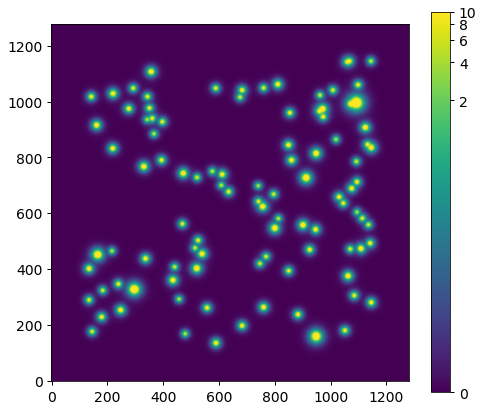

In [522]:
plt.figure(figsize=(8,7))
im = plt.imshow(image_gs, vmin=0, vmax=10, norm=norm1, origin="lower")
plt.colorbar(im)

In [518]:
from skimage.transform import resize
image_size_resize = image_size + 2 * pad_size//K
image_gs_resize = resize(image_gs, output_shape=(image_size_resize, image_size_resize), order=3,
                         cval=0, mode='constant', anti_aliasing=True, anti_aliasing_sigma=(1-image_size_resize/image_Kpsize)/2.)
image = image_gs_resize[pad_size//K:-pad_size//K, pad_size//K:-pad_size//K]

noise_image = galsim.ImageF(image_size, image_size)
gauss_noise = galsim.GaussianNoise(rng, sigma=math.sqrt(noise_variance))
noise_image.addNoise(gauss_noise)
image += 1 + noise_image.array

Text(0.5, 1.0, 'Astropy Image')

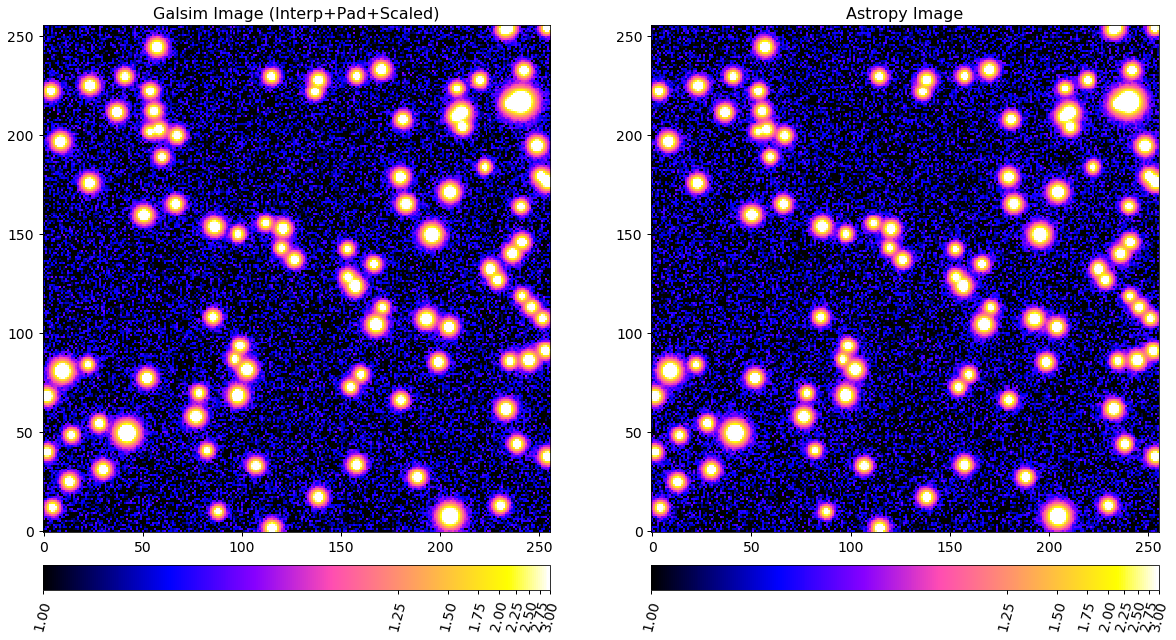

In [519]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,11))
im1 = ax1.imshow(image, vmin=1, vmax=3, norm=norm1, origin="lower", cmap="gnuplot2")
ax1.set_title("Galsim Image (Interp+Pad+Scaled)")
colorbar(im1, loc="bottom", pad=0.3)
im2 = ax2.imshow(image_astropy, vmin=1, vmax=3, norm=norm1, origin="lower", cmap="gnuplot2")
colorbar(im2, loc="bottom", pad=0.3)
ax2.set_title("Astropy Image")

Comparing the two images, they are very silimar and the dipole pattern is reduced.

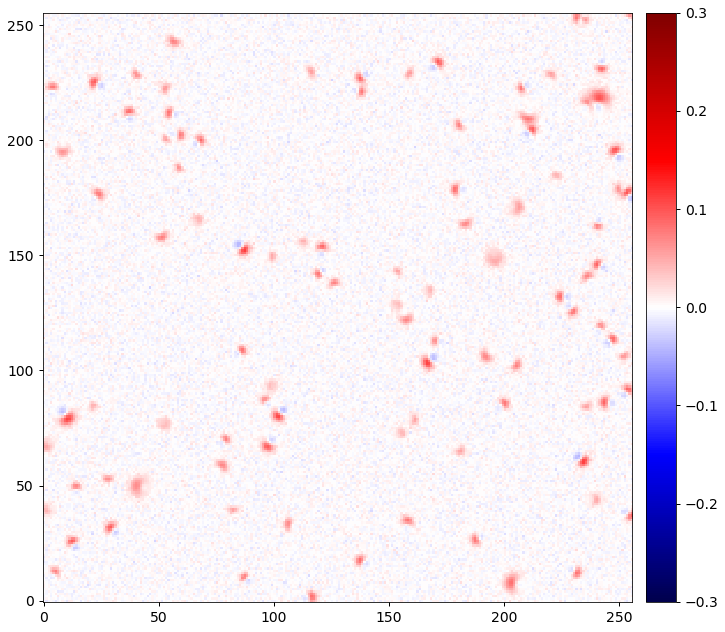

In [523]:
plt.figure(figsize=(10,9))
im = plt.imshow(np.log10(image/image_astropy), cmap='seismic', aspect='equal', vmin=-0.3, vmax=0.3, origin='lower')
colorbar(im)
plt.tight_layout()